In [2]:
import torch
from pytorch_metric_learning import losses
import math

import matplotlib.pyplot as plt

In [3]:
def soft_histogram(x, bins=100, range=(-4, 4), sigma=0.5):
    """Approximates a histogram with soft binning using a Gaussian kernel."""
    bin_edges = torch.linspace(*range, bins, device=x.device)
    x = x.unsqueeze(1)  # Shape: (n_samples, 1)
    bin_edges = bin_edges.unsqueeze(0)  # Shape: (1, bins)
    
    # Gaussian kernel density estimate (soft assignment to bins)
    weights = torch.exp(-0.5 * ((x - bin_edges) / sigma) ** 2)
    weights = weights / (sigma * (2 * torch.pi) ** 0.5)
    hist = weights.sum(dim=0)
    
    # Normalize to make it a probability distribution
    hist = hist / (hist.sum() + 1e-8)
    return hist

def jensen_shannon_loss(Q, bins=100, eps=1e-8):
    m = sum(Q) / len(Q) + eps
    js_pos = sum(sum([q * (q / m + eps).log() for q in Q]) / len(Q)) / math.log(len(Q))

    m0 = sum(Q[:2]) / 2 + eps
    m1 = sum(Q[2:]) / 2 + eps
    js_neg = 1 - (0.5 * sum(m0 * (m0 / m + eps).log()) + 0.5 * sum(m1 * (m1 / m + eps).log()))

    entropy0 = -1.0 * sum(m0 * (m0).log()) / math.log(bins)
    entropy1 = -1.0 * sum(m1 * (m1).log()) / math.log(bins)
    entropy = 0.5 * (1 - entropy0) + 0.5 * (1 - entropy1)

    print(f"JS_pos: {js_pos.item():.4f}, JS_neg: {js_neg.item():.4f}, Entropy: {entropy.item():.4f}")
    return js_pos + js_neg + 0.3 * entropy

def ntx_loss(Q):
    ntx_loss = losses.NTXentLoss(temperature=0.5)
    loss = ntx_loss(torch.stack(Q), torch.tensor([0, 0, 1, 1]))

    print(f"NTX Loss: {loss.item():.4f}")
    return loss

def update_step(samples, lr=1e-1, bins=100, loss_fn="JSD"):
    samples = samples.clone().detach().requires_grad_(True)
    
    Q = [soft_histogram(dist, bins=bins) for dist in samples]

    if loss_fn == "JSD":
        loss = jensen_shannon_loss(Q, bins=bins)
    elif loss_fn == "NTX":
        loss = ntx_loss(Q)
    else:
        raise ValueError("Invalid loss function specified. Use 'JSD' or 'NTX'.")

    loss.backward()

    # Gradient update step
    with torch.no_grad():
        samples = samples - lr * samples.grad + torch.randn_like(samples) * 0.01

    samples.clamp_(-4, 4)
    return samples.detach()

In [8]:
def plot_evolution(loss_fn="JSD"):
    lr = 250
    n_samples = 1000

    torch.manual_seed(0)
    x = torch.linspace(-4, 4, 1000)

    timesteps = torch.arange(0, 100)
    norm_timesteps = timesteps / timesteps.max()

    # Distributions
    ls_dist = [
        torch.distributions.normal.Normal(loc=1.0, scale=0.8),
        torch.distributions.normal.Normal(loc=0.5, scale=1.),
        torch.distributions.normal.Normal(loc=0.0, scale=1.),
        torch.distributions.normal.Normal(loc=0.25, scale=0.6)
    ]
    ls_color = ["#1f77b4", "#2ca02c", "#d62728", "#9467bd"]

    traj = torch.zeros(len(timesteps), len(ls_dist), n_samples)
    traj[0] = torch.stack([dist.sample((n_samples,)) for dist in ls_dist])
        
    for t in timesteps[1:]:
        traj[t] = update_step(traj[t-1], lr=lr, loss_fn=loss_fn, bins=500)

    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True, gridspec_kw={'width_ratios': [1, 5, 1]})

    traj_flat = traj.flatten(1)
    color_idx = torch.arange(4).view(-1, 1).expand(4, 1000).flatten()

    for idx in torch.randperm(traj_flat.size(1)):
        ax[1].plot(norm_timesteps, traj_flat[:, idx], color=ls_color[color_idx[idx]], alpha=0.05, linewidth=1)

    ax[1].set_xlim([0, 1])

    # Final distributions
    ls_prob_final = [soft_histogram(traj[-1, i], bins=x.size(0), range=(-4, 4), sigma=0.2) for i in range(len(ls_dist))]
    max_prob_final = max([p.max() for p in ls_prob_final])

    for prob, color in zip(ls_prob_final, ls_color):
        scaled_prob = 0.1 * prob / max_prob_final

        ax[2].fill_betweenx(x, 1.0, 1.0 + scaled_prob, color=color, alpha=0.2, step='mid')
        ax[2].plot(1.0 + scaled_prob, x, color=color, lw=2)

    # Initial distributions (colored separately)
    ls_prob_init = [dist.log_prob(x).exp() for dist in ls_dist]
    max_prob_init = max([p.max() for p in ls_prob_init])

    for prob, color in zip(ls_prob_init, ls_color):
        scaled_prob = -0.1 * prob / max_prob_init

        ax[0].fill_betweenx(x, 0.0, 0.0 + scaled_prob, color=color, alpha=0.3, step='mid')
        ax[0].plot(0.0 + scaled_prob, x, color=color, lw=2, label='Initial Left Mode')

    for i in range(3):
        ax[i].set_ylim([-4, 4])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        for line in ax[i].spines.values():
            line.set_color('black')
            line.set_linewidth(2.5)

    fig.subplots_adjust(wspace=0.1)
    plt.show()

JS_pos: 0.0637, JS_neg: 0.9466, Entropy: 0.1069
JS_pos: 0.0624, JS_neg: 0.9449, Entropy: 0.1069
JS_pos: 0.0613, JS_neg: 0.9432, Entropy: 0.1070
JS_pos: 0.0605, JS_neg: 0.9415, Entropy: 0.1070
JS_pos: 0.0600, JS_neg: 0.9397, Entropy: 0.1070
JS_pos: 0.0596, JS_neg: 0.9380, Entropy: 0.1070
JS_pos: 0.0595, JS_neg: 0.9361, Entropy: 0.1069
JS_pos: 0.0595, JS_neg: 0.9344, Entropy: 0.1069
JS_pos: 0.0596, JS_neg: 0.9326, Entropy: 0.1069
JS_pos: 0.0600, JS_neg: 0.9306, Entropy: 0.1069
JS_pos: 0.0605, JS_neg: 0.9286, Entropy: 0.1069
JS_pos: 0.0611, JS_neg: 0.9266, Entropy: 0.1068
JS_pos: 0.0619, JS_neg: 0.9245, Entropy: 0.1068
JS_pos: 0.0628, JS_neg: 0.9222, Entropy: 0.1068
JS_pos: 0.0638, JS_neg: 0.9200, Entropy: 0.1068
JS_pos: 0.0649, JS_neg: 0.9178, Entropy: 0.1068
JS_pos: 0.0660, JS_neg: 0.9155, Entropy: 0.1068
JS_pos: 0.0673, JS_neg: 0.9131, Entropy: 0.1068
JS_pos: 0.0685, JS_neg: 0.9109, Entropy: 0.1068
JS_pos: 0.0699, JS_neg: 0.9085, Entropy: 0.1068
JS_pos: 0.0713, JS_neg: 0.9060, Entropy:

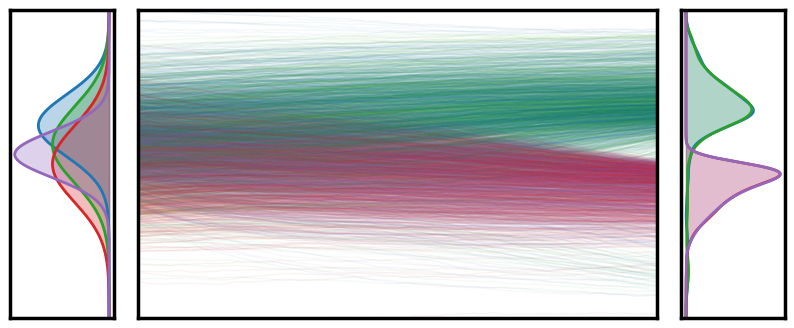

In [9]:
plot_evolution(loss_fn="JSD")

NTX Loss: 1.0120
NTX Loss: 0.9290
NTX Loss: 0.8214
NTX Loss: 0.7041
NTX Loss: 0.6004
NTX Loss: 0.5228
NTX Loss: 0.4674
NTX Loss: 0.4280
NTX Loss: 0.3991
NTX Loss: 0.3770
NTX Loss: 0.3598
NTX Loss: 0.3460
NTX Loss: 0.3346
NTX Loss: 0.3249
NTX Loss: 0.3168
NTX Loss: 0.3098
NTX Loss: 0.3038
NTX Loss: 0.2985
NTX Loss: 0.2939
NTX Loss: 0.2897
NTX Loss: 0.2861
NTX Loss: 0.2828
NTX Loss: 0.2799
NTX Loss: 0.2772
NTX Loss: 0.2748
NTX Loss: 0.2727
NTX Loss: 0.2708
NTX Loss: 0.2690
NTX Loss: 0.2674
NTX Loss: 0.2659
NTX Loss: 0.2645
NTX Loss: 0.2633
NTX Loss: 0.2621
NTX Loss: 0.2611
NTX Loss: 0.2601
NTX Loss: 0.2592
NTX Loss: 0.2584
NTX Loss: 0.2577
NTX Loss: 0.2570
NTX Loss: 0.2563
NTX Loss: 0.2557
NTX Loss: 0.2551
NTX Loss: 0.2546
NTX Loss: 0.2541
NTX Loss: 0.2536
NTX Loss: 0.2532
NTX Loss: 0.2528
NTX Loss: 0.2524
NTX Loss: 0.2520
NTX Loss: 0.2517
NTX Loss: 0.2513
NTX Loss: 0.2511
NTX Loss: 0.2508
NTX Loss: 0.2505
NTX Loss: 0.2502
NTX Loss: 0.2500
NTX Loss: 0.2498
NTX Loss: 0.2496
NTX Loss: 0.24

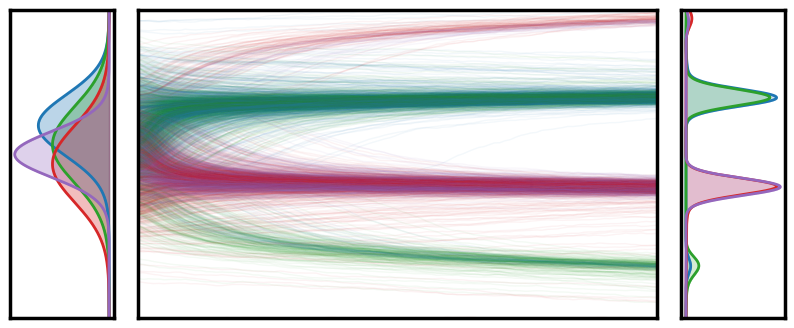

In [10]:
plot_evolution(loss_fn="NTX")